In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as st
import math
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import os as os
from src.plots import plot_prec_recall
from tqdm.notebook import tqdm

data_folder = 'data/arcface/subjects/'
# data_folder = 'data/noisy_20/'

In [2]:
def bag_median(feat, bag, trn_example=[]):
        
    if len(trn_example) == 0:
        trn_example = np.ones(len(bag), dtype='int')
        
    idx = np.flatnonzero(trn_example == 1)

    trn_feat = feat[:, idx]
    trn_bag = bag[idx]
    n_bags = max(trn_bag) + 1
    n = trn_feat.shape[1]
    n_dims = trn_feat.shape[0]
        
    min_obj = np.inf
    for i in range(n):
        mu = trn_feat[:, i].reshape([n_dims, 1])        
        dist = np.sum( np.absolute(trn_feat-mu),axis=0)
        
        obj = 0
        pred = np.zeros(n,dtype='int')
        for b in range(n_bags):
            idx = np.where( trn_bag == b)[0]           
            k = np.argmin( dist[idx] )
            obj = obj + dist[idx[k]]
            pred[idx[k]] = 1
            
        if obj < min_obj:
            pred_target = pred
            min_obj = obj
            best_mu = mu
        
    dist = np.sum(np.absolute(feat - best_mu.reshape([n_dims, 1])),axis=0)                        
    score = -dist
    
    return score

def median( feat, bag, trn_example=[]):
    if len( trn_example)==0:
        trn_example = np.ones(len(bag), dtype='int')
        
    mask = trn_example == 1
    mu = np.median( feat[:, mask], axis=1 )
    n_dims = feat.shape[0]
    dist = np.sum( np.abs(feat - mu.reshape([n_dims,1])), axis=0)
    score = -dist
        
    return score


def optimal( feat, target, trn_example=[] ):
    if len( trn_example)==0:
        trn_example = np.ones(len(bag), dtype='int')
        
    idx = np.where( (trn_example == 1) & (target==1))[0]
    mu = np.median( feat[:,idx], axis=1 )    
    n_dims = feat.shape[0]
    dist = np.sum( np.absolute(feat-mu.reshape([n_dims,1])),axis=0)
    score = -dist
    
    return score
    

def bayes_learn(features,bag,trn_example=[],sigma=1):
    
    n_faces = bag.size
    n_bags = max(bag)+1
    n_dims = features.shape[0]

    if len(trn_example) == 0:
        trn_example = np.ones(n_faces, dtype='int')
    
    logD = np.zeros([n_faces,n_bags])

    trn_bags = np.unique(bag[trn_example.astype(bool)])
    
    for i in range(n_faces):
        mu = features[:, i].reshape([n_dims, 1])        
        dist = np.sum(np.absolute(features - mu), axis=0)

        for b in trn_bags:
            mask = bag == b
            logD[i, b] = logsumexp(-dist[mask] / sigma)

    sumLogD = np.sum(logD, axis=1)
        
    P = np.zeros(n_faces)
    for b in range(n_bags):

        idx = np.flatnonzero(bag == b) 
        weight = sumLogD - logD[:, b]

        tmp = np.zeros([n_faces, len(idx)])
        cnt = 0
        for i in idx:
            mu = features[:, i].reshape([n_dims,1])        
            dist = np.sum(np.absolute(features - mu), axis=0)
            tmp[:, cnt] = -dist / sigma + weight
            cnt = cnt + 1

        K = np.max(tmp)
        tmp = tmp - K
        cnt = 0
        for i in idx:
            P[i] = np.sum(np.exp(tmp[:, cnt]))
            cnt = cnt + 1
        
        P[idx] = P[idx] / np.sum(P[idx])
        
    return P

In [3]:
def num_unique_numbers( x ):
    y = np.unique(x)
    num = y.size
    return num


def compute_prc(score,target):

    idx = np.where(score > -np.inf)
    min_score = np.min(score[idx])
    max_score = np.max(score)
        
    prec_ = []
    recall_ = []
    for th in np.linspace(max_score, min_score, num=100, endpoint=True):
        
        tp = np.sum((score >= th) & (target == 1))
        n_pos_preds = np.sum(score >= th)
        n_pos_targets = np.sum(target == 1)
        
        prec_.append(tp / n_pos_preds)
        recall_.append(tp / n_pos_targets)
 
    return prec_, recall_


def best_bag_score( score, bag):
    
    ubags = np.unique( bag )
    for b in ubags:
        idx = np.where( bag == b) [0]
        m = np.argmax( score[idx] )
        idx = np.delete(idx,m)
        score[idx] = -np.inf
            
    return score


def run(remove_single_detections = 0,
        remove_videos = 0,
        remove_images = 0,
        train_on_images = 1,
        train_on_videos = 1,
        eval_median = 1,
        eval_medoid = 1,
        eval_bayes = 1,
        save_features = 0):

    fnames = [f for f in os.listdir(data_folder)]

    score = {}
    score_one = {}
    
    if eval_median:
        score['median'] = []
        score_one['median'] = []

    if eval_medoid:
        score['medoid'] = []
        score_one['medoid'] = []
        
    if eval_bayes:
        score['bayes'] = []
        score_one['bayes'] = []

    targets = []

    n_subjects = 0

    for file in tqdm(fnames):
            
        subject_id = file.split('.')[0]
        subject = np.load(data_folder + file)

        target = subject['target']
        bag = subject['bag']
        features = subject['features']    
        is_img = subject['is_img']
        paths = subject['paths']

        if remove_single_detections:
            idx = np.empty(0, dtype='int')
            ubag = np.unique(bag)    
            for b in ubag:
                cidx = np.flatnonzero(bag == b)
                if len(cidx) > 1:
                    idx = np.append(idx, cidx)

            bag = bag[idx]
            target = target[idx]
            features = features[:, idx]
            is_img = is_img[idx]
            paths = paths[idx]

        mask = np.full(len(target), True)
        
        if remove_videos:
            mask &= is_img == 1

        if remove_images:
            mask &= is_img != 1

        bag = bag[mask]
        target = target[mask]
        features = features[:, mask]
        is_img = is_img[mask]
        paths = paths[mask]

        trn_example = np.zeros(bag.size, dtype='int')
        
        if train_on_images:
            mask = is_img == 1
            trn_example[mask] = 1

        if train_on_videos:
            mask = is_img == 0
            trn_example[mask] = 1
            
        _, bag = np.unique(bag, return_inverse=True)

        if num_unique_numbers( bag[np.flatnonzero(trn_example == 1)]) > 1: # requite at least 2 training bags
        
            def add_to_path_subj_features(features, bag, score, path_subj_features, method):
                features = features.T
                for b in np.unique(bag):
                    mask = bag == b
                    pred = np.argmax(score[mask])
                    path = paths[mask][pred]
                    feat = features[mask][pred]
                    path_subj_features[method][(path, subject_id)] = feat

            targets.extend(target)
            
            if eval_medoid:
            
                cscore1 = bag_median(features, bag, trn_example)    
                score['medoid'].extend(cscore1)
                score_one['medoid'].extend(best_bag_score(cscore1, bag))
                
                if save_features:
                    add_to_path_subj_features(features, bag, cscore1, path_subj_features, 'medoid')

            if eval_median:
                cscore2 = median(features, bag, trn_example)    
                score['median'].extend(cscore2)
                score_one['median'].extend(best_bag_score(cscore2, bag))

                if save_features:
                    add_to_path_subj_features(features, bag, cscore2, path_subj_features, 'median')

            if eval_bayes:
                cscore4 = bayes_learn(features, bag, trn_example, 1)  
                score['bayes'].extend(cscore4)
                score_one['bayes'].extend(best_bag_score(cscore4,bag))

                if save_features:
                    add_to_path_subj_features(features, bag, cscore4, path_subj_features, 'bayes')
                
            n_subjects = n_subjects + 1
    
    targets = np.array(targets)
    
    for k, v in score.items():
        score[k] = np.array(v)
        
    for k, v in score_one.items():
        score_one[k] = np.array(v)
        
    print()
    print(f"total num of subjects: {len(fnames)}")
    print(f"subjects used for evaluation: {n_subjects}")
    print(f"bags used for evaluation: {targets.sum()}")
    
    return score, targets, score_one


In [4]:
def plot(title):
    plt.legend()
    plt.grid(True)
    plt.xlabel('recall')
    plt.ylabel('prec')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('no-one-face-per-image constraint')

In [5]:
ijbb = np.genfromtxt('resources/ijbb_faces.csv', dtype=str, delimiter=",")

## Evaluate methods

### Train on images

In [11]:
# Train on images

path_subj_features = {
    'median': {},
    'medoid': {},
    'bayes': {}
}

run_1 = run(
    remove_single_detections = 0,
    remove_videos = 0,
    remove_images = 0,
    train_on_images = 1,
    train_on_videos = 0,
    eval_median = 1,
    eval_medoid = 1,
    eval_bayes = 1,
    save_features = 0
)



total num of subjects: 1845
subjects used for evaluation: 1843
bags used for evaluation: 68074


### Compute PRC and display

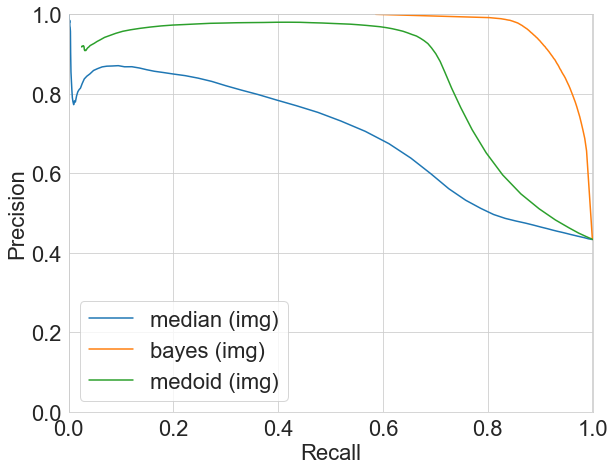

In [12]:
score, targets, score_one = run_1

if 'median' in score:
    prec, recall = compute_prc(score['median'], targets)
    plt.plot(recall, prec, label='median (img)', c='tab:blue')

if 'bayes' in score:
    prec, recall = compute_prc(score['bayes'], targets)
    plt.plot(recall, prec, label='bayes (img)', c='tab:orange')
    
if 'medoid' in score:
    prec, recall = compute_prc(score['medoid'], targets)
    plt.plot(recall, prec, label='medoid (img)', c='tab:green')

plot_prec_recall()

### Train on all 

In [13]:
path_subj_features = {
    'median': {},
    'medoid': {},
    'bayes': {}
}

run_2 = run(
    remove_single_detections = 0,
    remove_videos = 0,
    remove_images = 0,
    train_on_images = 1,
    train_on_videos = 1,
    eval_median = 1,
    eval_medoid = 1,
    eval_bayes = 1,
    save_features = 0
)



total num of subjects: 1845
subjects used for evaluation: 1845
bags used for evaluation: 68087


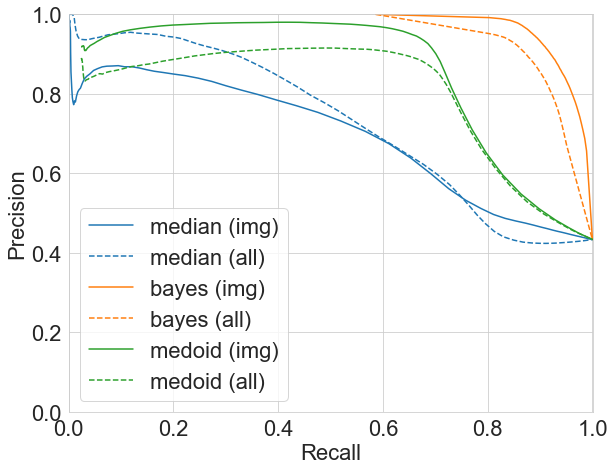

In [14]:
score1, targets1, score_one1 = run_1
score2, targets2, score_one2 = run_2

if 'median' in score1:
    prec, recall = compute_prc(score1['median'], targets1)
    plt.plot(recall, prec, label='median (img)', c='tab:blue')

if 'median' in score2:
    prec, recall = compute_prc(score2['median'], targets2)
    plt.plot(recall, prec, label='median (all)', c='tab:blue', ls='--')

if 'bayes' in score1:
    prec, recall = compute_prc(score1['bayes'], targets1)
    plt.plot(recall, prec, label='bayes (img)', c='tab:orange')

if 'bayes' in score2:
    prec, recall = compute_prc(score2['bayes'], targets2)
    plt.plot(recall, prec, label='bayes (all)', c='tab:orange', ls='--')
    
if 'medoid' in score1:
    prec, recall = compute_prc(score1['medoid'], targets1)
    plt.plot(recall, prec, label='medoid (img)', c='tab:green')
    
if 'medoid' in score2:
    prec, recall = compute_prc(score2['medoid'], targets2)
    plt.plot(recall, prec, label='medoid (all)', c='tab:green', ls='--')

plot_prec_recall(name='results/prc.png')

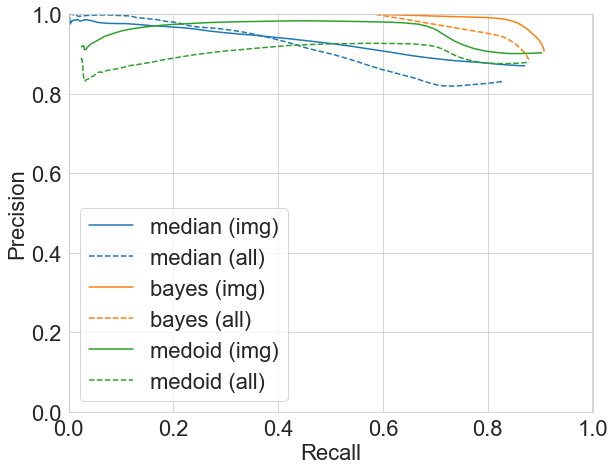

In [15]:
score1, targets1, score_one1 = run_1
score2, targets2, score_one2 = run_2

if 'median' in score1:
    prec, recall = compute_prc(score_one1['median'], targets1)
    plt.plot(recall, prec, label='median (img)', c='tab:blue')

if 'median' in score2:
    prec, recall = compute_prc(score_one2['median'], targets2)
    plt.plot(recall, prec, label='median (all)', c='tab:blue', ls='--')

if 'bayes' in score1:
    prec, recall = compute_prc(score_one1['bayes'], targets1)
    plt.plot(recall, prec, label='bayes (img)', c='tab:orange')

if 'bayes' in score2:
    prec, recall = compute_prc(score_one2['bayes'], targets2)
    plt.plot(recall, prec, label='bayes (all)', c='tab:orange', ls='--')
    
if 'medoid' in score1:
    prec, recall = compute_prc(score_one1['medoid'], targets1)
    plt.plot(recall, prec, label='medoid (img)', c='tab:green')
    
if 'medoid' in score2:
    prec, recall = compute_prc(score_one2['medoid'], targets2)
    plt.plot(recall, prec, label='medoid (all)', c='tab:green', ls='--')

plot_prec_recall(name='results/prc_constrained.png')

In [18]:
ijbb_features_bayes = []
ijbb_features_median = []
ijbb_features_medoid = []
valid_paths = []

fake_feature_vector = np.ones(512) / np.sqrt(512)

for i, row in enumerate(ijbb):
    path, subj = row[0], row[6]
    
    if (path, subj) in path_subj_features['median']:
        valid_paths.append(i)
        ijbb_features_median.append(path_subj_features['median'][(path, subj)])
    else:
        ijbb_features_median.append(fake_feature_vector)
        
    if (path, subj) in path_subj_features['medoid']:
        valid_paths.append(i)
        ijbb_features_medoid.append(path_subj_features['medoid'][(path, subj)])
    else:
        ijbb_features_medoid.append(fake_feature_vector)
        
    if (path, subj) in path_subj_features['bayes']:
        valid_paths.append(i)
        ijbb_features_bayes.append(path_subj_features['bayes'][(path, subj)])
    else:
        ijbb_features_bayes.append(fake_feature_vector)

ijbb_features_bayes = np.array(ijbb_features_bayes)
ijbb_features_median = np.array(ijbb_features_median)
ijbb_features_medoid = np.array(ijbb_features_medoid)
valid_paths = np.array(valid_paths)

np.save('ijbb_features_bayes', ijbb_features_bayes) 
np.save('ijbb_features_median', ijbb_features_median) 
np.save('ijbb_features_medoid', ijbb_features_medoid) 
np.save('valid_paths.npy', list(set(valid_paths)))